In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import gseapy as gp
import networkx as nx
import numpy as np

import pandas as pd
# This option is needed for printing all the information from the pandas dataframes
pd.set_option('display.max_colwidth', None)

# Information on Communities Characterisation

In this notebook you will find instructions on how to find useful information regarding the different communities found in each tissue.

Inside the `figures` folder, you can find, for each tissue, which communities provide a better prediction power for each tissue, when using their genes.

## Interesting communities

A python dictionary, saved in `interesting_communitites.pkl` and generated using code in the `13_plots_for_paper` notebook, is available in this repository to more easily access the community IDs that can achieve prediction power as defined in the paper:

In [2]:
interesting_communities = pickle.load(open('results/interesting_communitites.pkl','rb'))

In [4]:
interesting_communities['Brain_Hippocampus']

[4, 5, 6, 7, 8, 16, 18, 19, 20, 21, 30, 31, 32, 33, 34]

## General information for one tissue

The following function prints latex code in order to show the general figure of community prediction for one tissue

In [21]:
def print_tissue_header(tissue):
    print(f"\\section*{{{tissue.replace('_', ' ')}}}")
    
    print('\\begin{figure}[h!]')
    print('\\centering')
    print(f'\\includegraphics[width=.9\\textwidth]{{figures/tissue_prediction_from_{tissue}.pdf}}')
    print('\\end{figure}')

Here it is the function's output for the Brain Hippocampus:

In [22]:
print_tissue_header('Brain_Hippocampus')

\section*{Brain Hippocampus}
\begin{figure}[h!]
\centering
\includegraphics[width=.9\textwidth]{figures/tissue_prediction_from_Brain_Hippocampus.pdf}
\end{figure}


The following function, will create output for a specific community in a tissue, including the genes presented, enrichment analysis and the co-correlation network structure. 

We provide options to print LaTeX text or just show the images inside the notebook, as illustrated by the examples in the next cells.

In [39]:
def show_info_from_community_id(tissue, community_id, print_latex=True):
    print(f'\\subsection*{{Community with ID {community_id}}}' if print_latex else f'Community with ID {community_id}' )
    
    dic_community = pickle.load(open("svm_results/" + tissue + '_' + str(community_id) + ".pkl", "rb"))
    print("This community has the following genes: ", end='')
    print(*dic_community['genes'], sep = ", ", end='')
    print('\n\\\\' if print_latex else '\n')
    
    enr = gp.enrichr(gene_list=dic_community['genes'],
                     organism='human',
                     description=tissue + "_" + str(community_id),
                     gene_sets='Reactome_2016',
                     no_plot=True, # skip plotting, because you don't need these figures
                     cutoff=0.05,
                     outdir='results/EnrichClass')
    
    filtered_df = enr.results[enr.results['Adjusted P-value'] < 0.05].loc[:, ['Adjusted P-value', 'Term']]
    #display(filtered_df.loc[:, ['Adjusted P-value', 'Term']])
    if filtered_df.shape[0] == 0:
        print('This community has no enriched pathways below adjusted p-value $< 0.05$.')
    elif print_latex:
        print(filtered_df.to_latex(index=False, 
                                   longtable=True, 
                                   column_format='p{2.4cm}p{14.5cm}', 
                                   escape=False, 
                                   header=['Adjusted \\newline P-value', 'Term'],
                                  caption=f'Enrichment for community {community_id}'))
    else:
        print('Enriched Reactome pathways:')
        display(filtered_df)
    print()
    
    # Displaying upper triangle latex table
    com_genes = pd.read_pickle("data/corr_" + tissue + ".pkl").loc[dic_community['genes'],dic_community['genes']]
    com_genes = com_genes.replace([np.inf], np.nan).fillna(0)
    com_genes = com_genes.round(2)
    
    tril_indices = np.tril(np.ones(com_genes.shape)).astype(np.bool)
    com_genes[tril_indices] = np.nan

    df_subset = com_genes.iloc[:-1,1:] # Removing first column and last row
    header_names = [f'\\rot{{{head_name}}}' for head_name in df_subset.columns.values]
    if print_latex:
        print(df_subset.to_latex(longtable=True, escape=False, na_rep='', header=header_names, 
                                 caption=f'Connectivity of community {community_id}'))
    else:
        print(f'Connectivity of community {community_id}:')
        display(df_subset.style.format(None, na_rep="-"))
    print()

    # Displaying the network - it needs to reload everything because of previous round()
    com_genes = pd.read_pickle("data/corr_" + tissue + ".pkl").loc[dic_community['genes'],dic_community['genes']]
    com_genes = com_genes.replace([np.inf], np.nan).fillna(0)
    com_genes = np.tanh(com_genes) # Inverse of fisher-z transform
    com_genes = com_genes.round(2)
    com_genes[com_genes < 0.8] = 0
    
    com_graph = nx.from_pandas_adjacency(com_genes) 
    plt.figure(figsize=(20, 10))
    try:
        pos = nx.nx_agraph.graphviz_layout(com_graph)
    except ImportError:
        pos = nx.spring_layout(com_graph, iterations=20, k=20)
    #nx.draw_networkx(com4_graph, with_labels=True)
    nx.draw_networkx_edges(com_graph, pos, edge_color="m")
    nx.draw_networkx_nodes(com_graph, pos, alpha=0.6)
    #nx.draw_networkx_edges(com4_graph, pos, alpha=0.4, node_size=0, width=1, edge_color="k")
    labels = nx.get_edge_attributes(com_graph,'weight')
    nx.draw_networkx_edge_labels(com_graph,pos,edge_labels=labels,label_pos=0.6, font_size=15)
    _=nx.draw_networkx_labels(com_graph, pos, font_size=20, font_weight='bold')
    
    plt.tight_layout()
    if print_latex:
        plt.savefig(f'figures/corr_network{tissue}_{community_id}.pdf', bbox_inches = 'tight', pad_inches = 0)
        plt.close()

        print('\\begin{figure}[h!]')
        print('\\centering')
        print(f'\\includegraphics[width=.5\\textwidth]{{figures/corr_network{tissue}_{community_id}.pdf}}')
        print(f'\\caption{{Community {community_id} structure. Only showing connections with correlation greater than 0.8}}')
        print('\\end{figure}')
    else:
        print(f'Community {community_id} structure. Only showing connections with correlation greater than 0.8:')
        plt.show()

Here is an example with the LaTeX text for community with ID 5 in the Brain Hippocampus. Note that when LaTeX option is activated (like in the following cell), an image with the network structure of that community will be created in the `figures` folder. In this example, the resulting file will be called `figures/corr_networkBrain_Hippocampus_5.pdf`

In [ ]:
show_info_from_community_id('Brain_Hippocampus', interesting_communities['Brain_Hippocampus'][1])

\subsection*{Community with ID 5}
This community has the following genes: STK32B, PDGFRA, VCAN, PTPRZ1, AFAP1L2, HIP1R, SMOC1, MEGF11, CSPG4, FERMT1, TNR, PCDH15, MYT1, LHFPL3, DSCAM
\\
\begin{longtable}{p{2.4cm}p{14.5cm}}
\caption{Enrichment for community 5}\\
\toprule
Adjusted \newline P-value &                                                                                        Term \\
\midrule
\endhead
\midrule
\multicolumn{2}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
                 0.016832 &                                    Defective CHST3 causes SEDCJD Homo sapiens R-HSA-3595172 \\
                 0.008416 &                                      Defective CHSY1 causes TPBS Homo sapiens R-HSA-3595177 \\
                 0.005611 &            Defective CHST14 causes EDS, musculocontractural type Homo sapiens R-HSA-3595174 \\
                 0.011002 &                                    Dermatan sulfate biosynthesis Homo sapiens R-HSA-202292

If you just want to see the information directly in this notebook without any LaTeX text, and without saving any file in disk, you can do so by setting the argument `print_latex` to False, as shown in the following example:

Community with ID 5
This community has the following genes: STK32B, PDGFRA, VCAN, PTPRZ1, AFAP1L2, HIP1R, SMOC1, MEGF11, CSPG4, FERMT1, TNR, PCDH15, MYT1, LHFPL3, DSCAM

Enriched Reactome pathways:


,Adjusted P-value,Term
0,0.016832,Defective CHST3 causes SEDCJD Homo sapiens R-HSA-3595172
1,0.008416,Defective CHSY1 causes TPBS Homo sapiens R-HSA-3595177
2,0.005611,"Defective CHST14 causes EDS, musculocontractural type Homo sapiens R-HSA-3595174"
3,0.011002,Dermatan sulfate biosynthesis Homo sapiens R-HSA-2022923
4,0.014543,CS/DS degradation Homo sapiens R-HSA-2024101
5,0.022725,Defective B3GALT6 causes EDSP2 and SEMDJL1 Homo sapiens R-HSA-4420332
6,0.019478,"Defective B4GALT7 causes EDS, progeroid type Homo sapiens R-HSA-3560783"
7,0.017044,Defective B3GAT3 causes JDSSDHD Homo sapiens R-HSA-3560801
8,0.016826,Chondroitin sulfate biosynthesis Homo sapiens R-HSA-2022870
9,0.025836,Diseases associated with glycosaminoglycan metabolism Homo sapiens R-HSA-3560782



Connectivity of community 5:


,PDGFRA,VCAN,PTPRZ1,AFAP1L2,HIP1R,SMOC1,MEGF11,CSPG4,FERMT1,TNR,PCDH15,MYT1,LHFPL3,DSCAM
STK32B,0.670000,0.590000,0.730000,0.490000,0.400000,0.480000,0.530000,0.490000,0.550000,0.760000,0.640000,0.710000,0.800000,0.500000
PDGFRA,-,0.840000,0.920000,0.710000,0.560000,0.780000,0.740000,0.800000,0.690000,1.130000,0.760000,0.910000,0.860000,0.740000
VCAN,-,-,0.890000,0.630000,0.680000,0.730000,0.790000,0.630000,0.730000,0.930000,0.660000,0.650000,0.730000,0.600000
PTPRZ1,-,-,-,0.500000,0.440000,0.500000,0.630000,0.560000,0.540000,0.900000,0.820000,0.720000,1.030000,0.630000
AFAP1L2,-,-,-,-,0.570000,0.620000,0.580000,0.490000,0.640000,0.840000,0.490000,0.600000,0.660000,0.560000
HIP1R,-,-,-,-,-,0.870000,0.710000,0.790000,0.530000,0.710000,0.530000,0.680000,0.370000,0.640000
SMOC1,-,-,-,-,-,-,0.900000,0.940000,0.760000,0.920000,0.570000,0.780000,0.550000,0.660000
MEGF11,-,-,-,-,-,-,-,0.730000,0.770000,0.950000,0.560000,0.760000,0.650000,0.850000
CSPG4,-,-,-,-,-,-,-,-,0.520000,0.800000,0.550000,0.910000,0.530000,0.690000
FERMT1,-,-,-,-,-,-,-,-,-,0.830000,0.660000,0.630000,0.580000,0.640000



Community 5 structure. Only showing connections with correlation greater than 0.8:


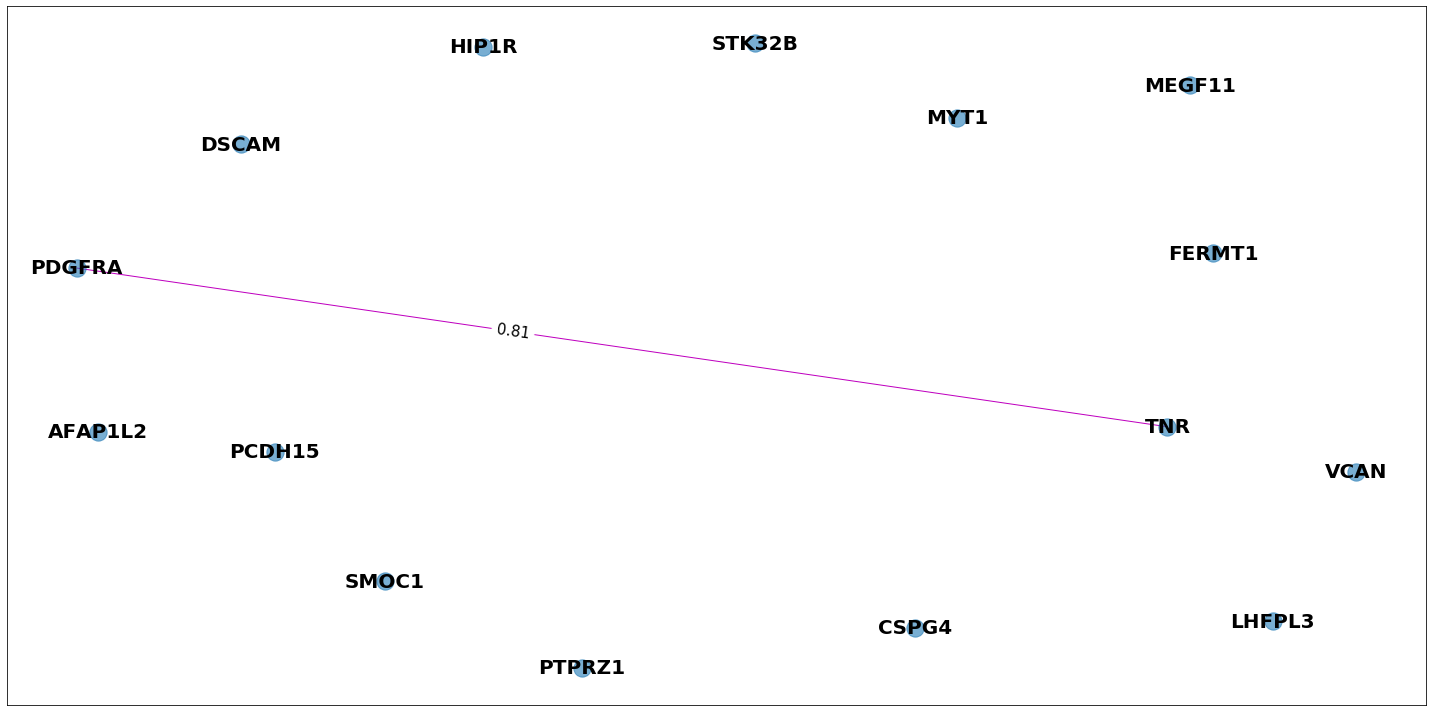

In [40]:
show_info_from_community_id('Brain_Hippocampus', 
                            interesting_communities['Brain_Hippocampus'][1],
                            print_latex=False)